## **Predicting Bee Species**
KMITL - Artificial Intelligence Technology (01416500)<br>
April 2022<br><br>

Author:<br>
**Piyawud Koonmanee - 63110119**<br>
**Nithiwat Pattrapong - 63110113**<br>
**Tulatorn Prakitjanuruk - 63110118**<br>
**Chananyu Kamolsuntron - 63110105**<br>



In [ ]:
# remove file
!rm -rf -I "/content/AI Tech Bees/"

rm: remove 1 argument recursively? y


In [ ]:
# reset variables
%reset 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# copy data from Google Drive to Colab's temporary storage for faster computational time
!cp -r "/content/drive/MyDrive/Colab Notebooks/AI Tech Bees" "/content/AI Tech Bees"

### **Data Preprocessing**

In [ ]:
# import general library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cv2 import imread, resize, imwrite, cvtColor, COLOR_BGR2RGB, COLOR_BGR2GRAY, IMREAD_UNCHANGED
from skimage.feature import hog
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
import joblib
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.models import Model
from os import listdir

plt.rcParams['figure.figsize'] = (14, 14) # set global plot size

In [ ]:
# load the labels
labels = pd.read_csv("/content/AI Tech Bees/datasets/labels.csv", index_col=0)

# check the dataframe
labels.head()

,genus
id,
520,1.0
3800,1.0
3289,1.0
2695,1.0
4922,1.0


#### **Resize and Retrieve Images**

In [ ]:
def resize_img(df, path, write):
    """
    Resize the image by half and write that image into a new, pre-existing folder.
    Returns the number of resized images.
    """
    counter = 0

    for index,row in df.iterrows():
        # read the image
        img_path = path + str(row.name) +'.jpg'
        img = imread(img_path, IMREAD_UNCHANGED)

        # resize the image by half
        img = resize(img, None, fx=0.5, fy=0.5)

        # write image to path
        write_img_path = write + str(row.name) + ".jpg"
        imwrite(write_img_path, img)
        counter += 1
    return counter

Original shape (200, 200, 3)
Resized shape (100, 100, 3)


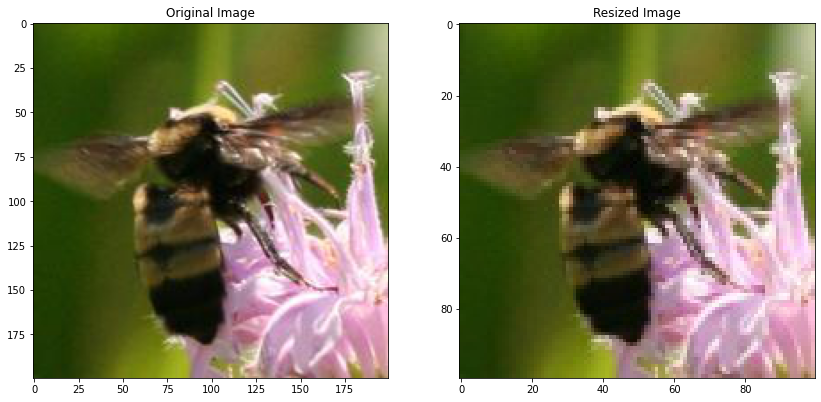

In [ ]:
# # resize image
# resize_img(labels, path = "/content/AI Tech Bees/datasets/Images/", write = "/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/datasets/resized_image")

original_img = plt.imread('/content/AI Tech Bees/datasets/Images/3226.jpg', IMREAD_UNCHANGED)
print("Original shape", original_img.shape)
resized_img = plt.imread('/content/AI Tech Bees/datasets/resized_image/3226.jpg', IMREAD_UNCHANGED)
print("Resized shape", resized_img.shape)

plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(original_img);

plt.subplot(1,2,2)
plt.title("Resized Image")
plt.imshow(resized_img);

In [ ]:
def get_image(row_id, path):
    """
    Read the image given file name. Returns numpy array in RGB format.
    """
    # read the image
    file_path = path + str(row_id) + ".jpg"
    img = imread(file_path, IMREAD_UNCHANGED)

    # convert image color to RGB
    img_rgb = cvtColor(img, COLOR_BGR2RGB)
    return np.array(img_rgb)

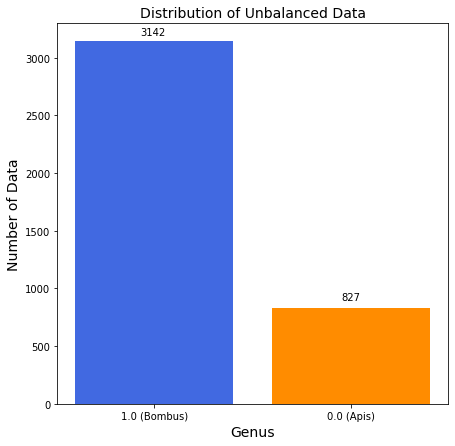

In [ ]:
# look at the distribution of the dataset
plt.figure(figsize=(7,7))
plt.bar(['1.0 (Bombus)','0.0 (Apis)'], labels.genus.value_counts(), color=['royalblue','darkorange'])
plt.xlabel("Genus", fontsize=14)
plt.ylabel("Number of Data", fontsize=14)
plt.title("Distribution of Unbalanced Data", fontsize=14)
plt.annotate(labels.genus.value_counts()[1],(-0.07,3200))
plt.annotate(labels.genus.value_counts()[0],(0.95,900))
plt.show()

From the cell above, we can see that Apis (0.0) has a significantly lesser amount of data compared to Bombus (1.0) - making the dataset unbalanced. Therefore, we will split it into 2 cases and compared them:<br>
1. Unbalanced Dataset - directly train the data
2. Balanced Dataset - equalize the amount of data from each class then train

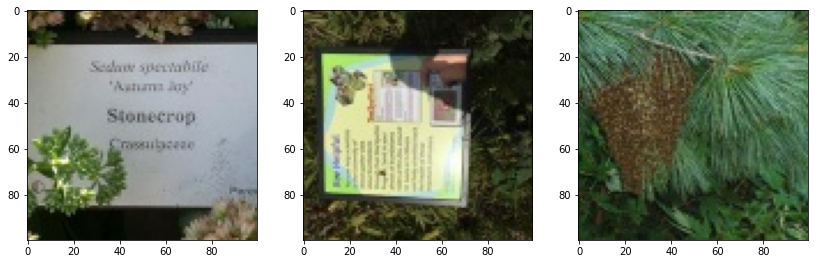

In [ ]:
# preview the dataset
path = "/content/AI Tech Bees/datasets/resized_image/"
plt.subplot(1,3,1)
plt.imshow(get_image(114, path));

plt.subplot(1,3,2)
plt.imshow(get_image(2129, path));

plt.subplot(1,3,3)
plt.imshow(get_image(2927, path));

From the cell above, we can see that some images don't contain a clear view of the bee. This might be a problem since the machine learning algorithm is learning from these and might produce an inaccurate prediction. Therefore, we will delete some images and see if the accuracy has improved or not.

#### **Create Features**

We will be using the Histogram of Oriented Gradient (HOG) to extract the edge of the bees from the image. This algorithm works by calculating the direction of intensity gradients.

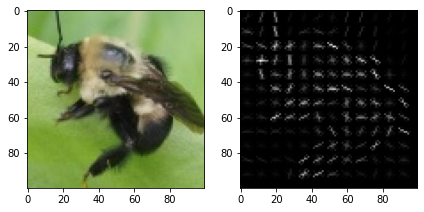

In [ ]:
# preview HOG
path = "/content/AI Tech Bees/datasets/resized_image/"
hog_features, hog_image = hog(get_image(4941, path),
                              visualize = True,
                              block_norm = 'L2-Hys',
                              pixels_per_cell = (8, 8))

# compare normal image with HOG image
plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.imshow(get_image(4941, path))
plt.subplot(1,2,2)
plt.imshow(hog_image, cmap = 'gray')

Then we will combine and stack the features into a single array, then standardized and reduce the dimensionality of the features to reduce the computational power.

In [ ]:
def create_features(img):
    '''
    This function generate features from the HOG and and color images.
    Returns the shape of single array containing those.
    '''
    # flatten three channel color image
    color_features = img.flatten()

    # convert image to grayscale
    gray_image = cvtColor(img,COLOR_BGR2GRAY)

    # get HOG features from grayscale image
    hog_features = hog(gray_image, block_norm='L2-Hys', pixels_per_cell=(8, 8))
    
    # combine color and hog features into a single array
    flat_features = np.hstack([color_features, hog_features])
    
    return flat_features

In [ ]:
def create_features_cnn(df, path):
    '''
    This function create features for the CNN while also scaling data.
    Returns stacked numpy array of the datafame. 
    
    Note: This function uses get_image() function.
    '''
    temp = []
    for img_id in df.index:
        # load image
        img = get_image(img_id, path)
        temp.append(img.astype(float))
    
    # stack the array
    data = np.stack(temp)

    # scale down the data
    data /= 255.0

    return data

In [ ]:
def create_feature_matrix(df, path):
    """
    Generate feature matrix from the dataframe.
    Return an array of features.
    
    Note: This function uses get_image() and create_feature() function
    """
    features_list = []
    for img_id in df.index:
        # load image
        img = get_image(img_id, path)
        
        # get features of image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def scale_reduce_features(train,test,n:int):
    """
    Standardized features and reduce dimensionality of the data using standard scaler and PCA.
    Return an array of training set, testing set, standard scaler fit and PCA fit.
    """
    ss = StandardScaler()

    # scale the features
    train_std = ss.fit_transform(train)
    test_stand = ss.transform(test)

    # reduce dimentionality of standardized data
    pca = PCA(n_components=n)
    train = pca.fit_transform(train_std)
    test = pca.transform(test_stand)

    return train, test, ss, pca

#### **Validation**

To validate our model, we will be using accuracy score, AUC score, confusion matrix and predicting user uploaded picture. For CNN, we will also be plotting the Loss and Accuracy vs Epochs to look for any overfitting.

In [ ]:
def verify_pic(clf,img, path, ss_verify, pca_verify):
    '''
    Takes in picture name and path and perform necessary image transformation to match the expected
    input data.
    Return the prediction from the model.
    '''
    img = get_image(img, path)

    # resize the image by half
    img = resize(img, (100,100))

    # print out images
    plt.figure(figsize=(5,5))
    plt.imshow(img)

    # create features and reshape
    data = create_features(img).reshape(1, -1)

    # reduce dimentionality of standardized data 
    # using the standardscaler and pca from the train dat
    data = ss_verify.transform(data)
    data = pca_verify.transform(data)

    # predict
    prediction = clf.predict(data)

    # predict probability
    prob_prediction = clf.predict_proba(data)

    if prediction == 1.0:
        return "1.0 - Bumble bee - Bombus - " + "({:.2f}% accuracy)".format(np.max(prob_prediction)*100)
    else:
        return "0.0 - Honey bee - Apis - " + "({:.2f}% accuracy)".format(np.max(prob_prediction)*100)

In [ ]:
def verify_pic_cnn(clf,img_id:int, path):
    '''
    Takes in picture name and path and perform necessary image transformation to match the input shape.
    Return the prediction from the model.
    '''
    img = get_image(img_id, path)

    # resize the image to 100x100 pixels
    img = resize(img, (100,100))

    # print out images
    plt.figure(figsize=(5,5))
    plt.imshow(img)

    # scale down the data
    data = img.astype(float)
    data /= 255.0

    # expan dimension for CNN layers
    data = np.expand_dims(data, axis=0)

    # predict
    prediction = clf.predict(data)

    # get maximum value
    classes = np.argmax(prediction, axis = 1)

    if classes == 1.0:
        return "1.0 - Bumble bee - Bombus - " + "({:.2f}% accuracy)".format(np.max(prediction)*100)
    else:
        return "0.0 - Honey bee - Apis - " + "({:.2f}% accuracy)".format(np.max(prediction)*100)

In [ ]:
def plot_confusion_matrix(y_test,y_pred):
    '''
    This function plots the confusion matrix.
    '''
    # create labels for the graph
    lab = ["0.0 - honey bees","1.0 - bumble bees"]

    # setup and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = lab)
    _, ax = plt.subplots(figsize=(7,7))
    disp.plot(ax=ax);

In [ ]:
def plot_roc_auc(y_test, CNN:bool, **kwargs):
    '''
    This function plots ROC curve and calculate AUC score.
    Return AUC score and plot graph.
    '''
    # extract data
    clf = kwargs.get('clf', None)
    X_test = kwargs.get('X_test', None)
    y_pred = kwargs.get('y_pred', None)

    if not CNN:
        # predict probabilities for X_test using predict_proba
        probabilities = clf.predict_proba(X_test)

        # select the probabilities for label 1.0
        y_proba = probabilities[:, 1]

        # calculate false positive rate and true positive rate at different thresholds
        fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=1)
    
    else:
        fpr, tpr, _ = roc_curve(y_test, y_pred)

    # calculate AUC
    roc_auc = auc(fpr, tpr)
    print("AUC Score: ",roc_auc)

    plt.figure(figsize=(5,5))
    plt.title('ROC Curve')

    # plot the false positive rate on the x axis and the true positive rate on the y axis
    roc_plot_ros = plt.plot(fpr, tpr, label='AUC = {:0.3f}'.format(roc_auc))

    plt.legend(loc=0)
    plt.plot([0,1], [0,1], ls='--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate');

In [ ]:
def plot_vs_epochs(model_history,epoch):
    '''
    This function plot Loss vs Epochs and Accuracy vs Epochs graphs from the given model history.

    Note: Does not work properly with the Early Stopping. The user has to put in the stopping epoch
    by themself. Otherwise, the maximum number allowed for max epoch will be use for x ticks.
    '''
    # plot trains and test loss
    plt.figure(figsize=(12,6))
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])

    # set x-ticks from epochs value
    plt.xticks(np.arange(0, epoch, step=1), np.arange(1, epoch+1, step=1))

    plt.title('Loss vs Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

    # plot trains and test accuracy
    plt.figure(figsize=(12,6))
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])

    # set x-ticks from epochs value
    plt.xticks(np.arange(0, epoch, step=1), np.arange(1, epoch+1, step=1))

    plt.title('Accuracy vs Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

### **Unbalanced Data**

In [ ]:
path = "/content/AI Tech Bees/datasets/resized_image/"

# create matrix
unbalanced_feature_matrix = create_feature_matrix(labels, path)

# splitting unbalanced data
X_train, X_test, y_train, y_test = train_test_split(unbalanced_feature_matrix, labels['genus'].values, test_size=0.2, random_state=0)

# call reduce dimensionality function
X_train_reduced, X_test_reduced, ss_verify, pca_verify = scale_reduce_features(X_train, X_test, 375)

# look at the distribution of the dataset
print(pd.Series(y_train).value_counts())

tcmalloc: large alloc 1209753600 bytes == 0x560a8e39e000 @  0x7f3462a5f1e7 0x7f34541d40ce 0x7f3454230715 0x7f3454230d1b 0x7f34542d1333 0x560a3b6cb11c 0x560a3b6caef0 0x560a3b73f123 0x560a3b6cc7aa 0x560a3b73a8f6 0x560a3b739a2e 0x560a3b739723 0x560a3b737bd0 0x560a3b6caff9 0x560a3b6caef0 0x560a3b73e9a3 0x560a3b7bece5 0x560a3b73bc03 0x560a3b7bece5 0x560a3b73bc03 0x560a3b7bece5 0x560a3b6caf9d 0x560a3b7bcd4d 0x560a3b73eec8 0x560a3b6cc7aa 0x560a3b73a8f6 0x560a3b6cc7aa 0x560a3b73ab4f 0x560a3b739a2e 0x560a3b6cd13c 0x560a3b6cd341


1.0    2531
0.0     644
dtype: int64


#### **SVM**

Since SVM really takes a lot of time to fit a huge dataset like this (more than 3 hours), we will use the ensemble learning technique (Bagging Classifier) to train on the subset of the dataset and combine it all together.

In [ ]:
# define support vector classifier
svm = SVC(probability = True, random_state = 42)
svm_bag = BaggingClassifier(svm, max_samples = 0.1, n_estimators = 20, random_state = 9, n_jobs = -1)
                        
param_grid = {'base_estimator__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
              'base_estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'base_estimator__kernel': ['poly', 'sigmoid', 'rbf', 'linear'],
              'base_estimator__degree': [3]}
 
svm_grid = GridSearchCV(svm_bag, param_grid, refit = True, verbose = 4, scoring='accuracy')

# # fit and save model
# svm_grid.fit(X_train_reduced,y_train)
# joblib.dump(svm_grid, '/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/unbalanced_svm')

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=poly;, score=0.798 total time=   3.2s
[CV 2/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=poly;, score=0.797 total time=   1.9s
[CV 3/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=poly;, score=0.797 total time=   1.9s
[CV 4/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=poly;, score=0.797 total time=   1.9s
[CV 5/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=poly;, score=0.797 total time=   1.9s
[CV 1/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=sigmoid;, score=0.798 total time=   1.1s
[CV 2/5] END base_estimator__C=0.0

['/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/unbalanced_svm']

In [ ]:
# load model
unbalanced_svm = joblib.load('/content/AI Tech Bees/model/unbalanced_svm')

# print best parameter after tuning
print(unbalanced_svm.best_params_)
 
# print how the model looks after hyper-parameter tuning
print(unbalanced_svm.best_estimator_)

{'base_estimator__C': 0.001, 'base_estimator__degree': 3, 'base_estimator__gamma': 0.0001, 'base_estimator__kernel': 'poly'}
BaggingClassifier(base_estimator=SVC(C=0.001, gamma=0.0001, kernel='poly',
                                     probability=True, random_state=42),
                  max_samples=0.1, n_estimators=20, n_jobs=-1, random_state=9)


In [ ]:
# generate predictions
y_pred_svm = unbalanced_svm.predict(X_test_reduced)

# calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print('SVM accuracy (Unbalanced): ', accuracy_svm)

SVM accuracy (Unbalanced):  0.7695214105793451


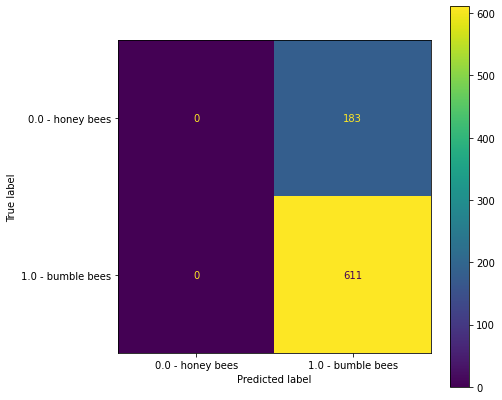

In [ ]:
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred_svm)

AUC Score:  0.6884351551250749


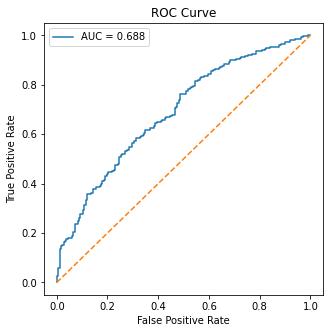

In [ ]:
# plot ROC curve
plot_roc_auc(y_test, CNN = False, clf = unbalanced_svm, X_test = X_test_reduced)

1.0 - Bumble bee - Bombus - (81.31% accuracy)


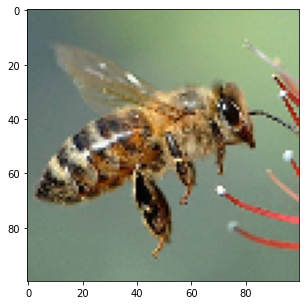

In [ ]:
# verify result
verify_unbalanced_svm = verify_pic(unbalanced_svm,"honeybee1","/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/datasets/verify_images/", ss_verify, pca_verify)
print(verify_unbalanced_svm)

1.0 - Bumble bee - Bombus - (71.95% accuracy)


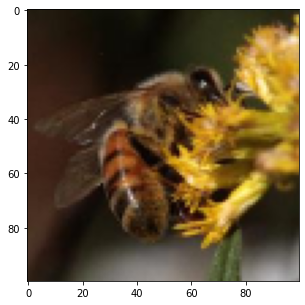

In [ ]:
# verify result (using test image)
verify_unbalanced_svm = verify_pic(unbalanced_svm,"2649","/content/AI Tech Bees/datasets/Images/", ss_verify, pca_verify)
print(verify_unbalanced_svm)

#### **Logistic Regression**

In [ ]:
# define logistic regression
lr = LogisticRegression()

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'max_iter': [500, 1000, 4000, 7000, 10000],
              'penalty': ['l2'],
              'random_state': [42]}
 
lr_grid = GridSearchCV(lr, param_grid, refit = True, verbose = 4, scoring='accuracy')

# # fit and save model
# lr_grid.fit(X_train_reduced,y_train)
# joblib.dump(lr_grid, '/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/unbalanced_lr')

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=newton-cg;, score=0.800 total time=   1.8s
[CV 2/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=newton-cg;, score=0.784 total time=   1.6s
[CV 3/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=newton-cg;, score=0.792 total time=   1.2s
[CV 4/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=newton-cg;, score=0.791 total time=   1.3s
[CV 5/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=newton-cg;, score=0.794 total time=   1.6s
[CV 1/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=lbfgs;, score=0.800 total time=   0.3s
[CV 2/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=lbfgs;, score=0.784 total time=   0.4s
[CV 3/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=lbfgs;, score=0.792 total time=   0.3s
[CV 4/5] END C=0.0001,

['/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/unbalanced_lr']

In [ ]:
# load model
unbalanced_lr = joblib.load('/content/AI Tech Bees/model/unbalanced_lr')

# print best parameter after tuning
print(unbalanced_lr.best_params_)
 
# print how the model looks after hyper-parameter tuning
print(unbalanced_lr.best_estimator_)

{'C': 0.0001, 'max_iter': 500, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg'}
LogisticRegression(C=0.0001, max_iter=500, random_state=42, solver='newton-cg')


In [ ]:
# generate predictions
y_pred_lr = unbalanced_lr.predict(X_test_reduced)

# calculate accuracy
accuracy_lr = accuracy_score(y_test,y_pred_lr)
print('LR accuracy (Unbalanced): ', accuracy_lr)

LR accuracy (Unbalanced):  0.7682619647355163


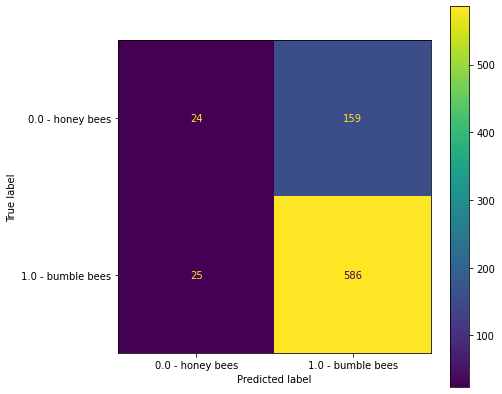

In [ ]:
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred_lr)

AUC Score:  0.6889449348465742


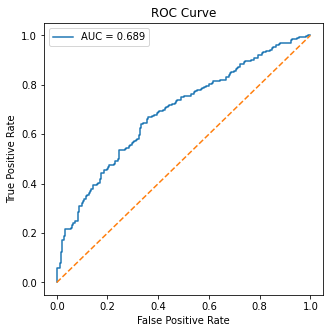

In [ ]:
# plot ROC curve
plot_roc_auc(y_test, CNN = False, clf = unbalanced_lr, X_test = X_test_reduced)

1.0 - Bumble bee - Bombus - (86.88% accuracy)


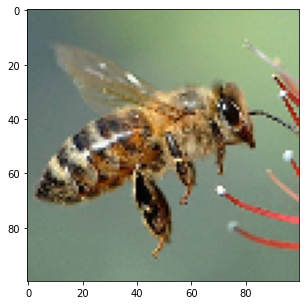

In [ ]:
# verify result
verify_unbalanced_lr = verify_pic(unbalanced_lr,"honeybee1","/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/datasets/verify_images/", ss_verify, pca_verify)
print(verify_unbalanced_lr)

1.0 - Bumble bee - Bombus - (80.28% accuracy)


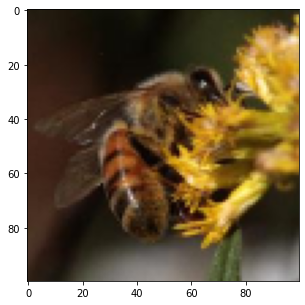

In [ ]:
# verify result (using test image)
verify_unbalanced_lr = verify_pic(unbalanced_lr,"2649","/content/AI Tech Bees/datasets/Images/", ss_verify, pca_verify)
print(verify_unbalanced_lr)

#### **CNN**

In [ ]:
# create features
path = "/content/AI Tech Bees/datasets/resized_image/"
cnn_features = create_features_cnn(labels, path)

# split data into 80% train, 10% eval, 10% test
X_train_cnn, X_test_and_val, y_train_cnn, y_test_and_val = train_test_split(cnn_features,
                                                    labels.genus.values,
                                                    test_size=0.2,
                                                    random_state=102
                                                    )

X_test_cnn, X_val_cnn, y_test_cnn, y_val_cnn = train_test_split(X_test_and_val,
                                                    y_test_and_val,
                                                    test_size=0.5,
                                                    random_state=102
                                                    )

In [ ]:
# build a model
img_rows, img_cols = 100, 100 # Resolution of inputs
color_channel = 3 # rgb
num_classes = 2  # apis and bombus

# change the labels to categorical
y_train_cnn = to_categorical(y_train_cnn, num_classes)
y_val_cnn = to_categorical(y_val_cnn, num_classes)

# initialize InceptionV3 as our base model
base_model =  InceptionV3(weights='imagenet', include_top=False)
    
# input format
input = Input(shape=(img_rows,img_cols,color_channel),name = 'image_input')

# connect the model together
output_base_model= base_model(input)

# add layers 
x = Flatten(name='flatten')(output_base_model)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', name='fc1', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', name='fc2', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax', name='predictions')(x)

unbalanced_cnn = Model(input, x)

# print out the model summary
unbalanced_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 fc1 (Dense)                 (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 fc2 (Dense)                 (None, 512)               262656

In [ ]:
# compile model
unbalanced_cnn.compile(loss = "categorical_crossentropy", optimizer = 'sgd', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min', min_delta=0.0001)

# # train model
# unbalanced_cnn_history = unbalanced_cnn.fit(X_train_cnn, y_train_cnn, batch_size = 20, epochs = 20, shuffle = True, verbose = 1,
#                                             validation_data = (X_val_cnn, y_val_cnn), callbacks = [early_stopping])

# # save model
# unbalanced_cnn.save('/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/unbalaced_cnn.h5')
# joblib.dump(unbalanced_cnn_history, '/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/unbalanced_cnn_history')

Epoch 1/20
159/159 [==============================] - 30s 142ms/step - loss: 0.6782 - accuracy: 0.7820 - val_loss: 0.6600 - val_accuracy: 0.7632
Epoch 2/20
159/159 [==============================] - 21s 130ms/step - loss: 0.5794 - accuracy: 0.7934 - val_loss: 0.6085 - val_accuracy: 0.7632
Epoch 3/20
159/159 [==============================] - 21s 130ms/step - loss: 0.4823 - accuracy: 0.8104 - val_loss: 0.5596 - val_accuracy: 0.8262
Epoch 4/20
159/159 [==============================] - 21s 130ms/step - loss: 0.4187 - accuracy: 0.8775 - val_loss: 0.4628 - val_accuracy: 0.8438
Epoch 5/20
159/159 [==============================] - 21s 134ms/step - loss: 0.3701 - accuracy: 0.9036 - val_loss: 0.4234 - val_accuracy: 0.8715
Epoch 6/20
159/159 [==============================] - 21s 130ms/step - loss: 0.3166 - accuracy: 0.9313 - val_loss: 0.4146 - val_accuracy: 0.8816
Epoch 7/20
159/159 [==============================] - 21s 130ms/step - loss: 0.2766 - accuracy: 0.9474 - val_loss: 0.4215 - val_ac

['/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/unbalanced_cnn_history']

CNN accuracy (Unbalanced):  0.8639798488664987


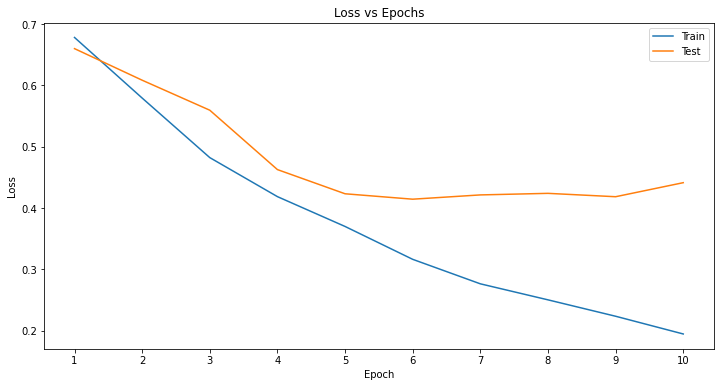

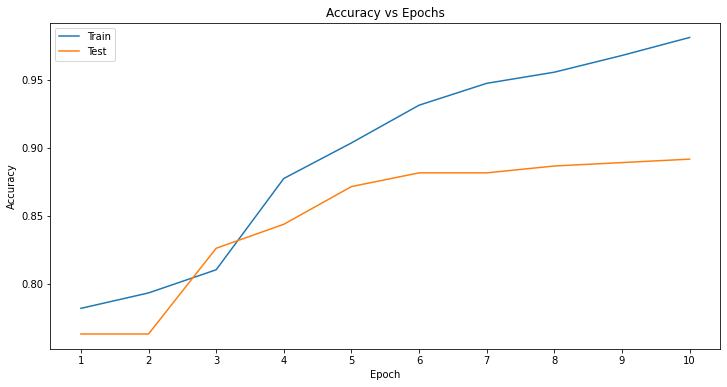

In [ ]:
# load model
unbalanced_cnn = load_model('/content/AI Tech Bees/model/unbalaced_cnn.h5')
unbalanced_cnn_history = joblib.load('/content/AI Tech Bees/model/unbalanced_cnn_history')

# generate predictions
y_pred_cnn = unbalanced_cnn.predict(X_test_cnn)
y_pred_cnn = y_pred_cnn.argmax(axis=-1)

# calculate accuracy
accuracy_cnn = accuracy_score(y_test_cnn,y_pred_cnn)
print('CNN accuracy (Unbalanced): ', accuracy_cnn)

# plot graphs
plot_vs_epochs(unbalanced_cnn_history, 10)

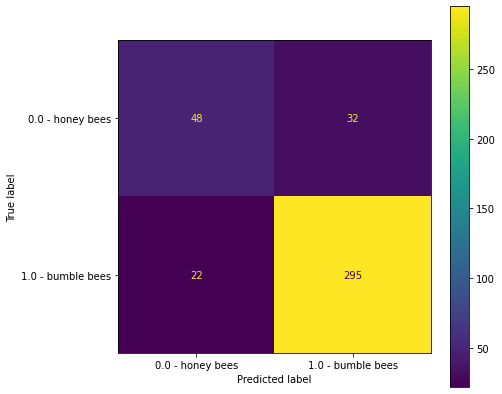

In [ ]:
# plot confusion matrix
plot_confusion_matrix(y_test_cnn,y_pred_cnn)

AUC Score:  0.7652996845425868


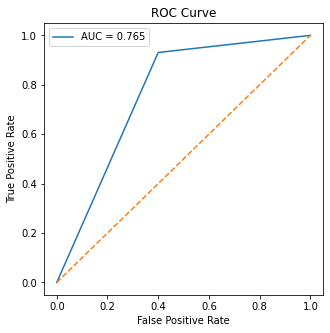

In [ ]:
# plot ROC curve
plot_roc_auc(y_test_cnn, CNN = True, y_pred = y_pred_cnn)

0.0 - Honey bee - Apis - (99.50% accuracy)


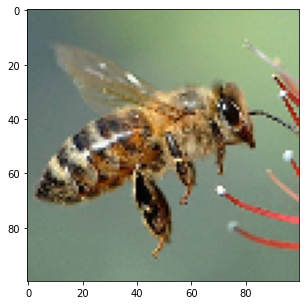

In [ ]:
# verify result
verify_unbalanced_cnn = verify_pic_cnn(unbalanced_cnn,"honeybee1","/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/datasets/verify_images/")
print(verify_unbalanced_cnn)

0.0 - Honey bee - Apis - (99.24% accuracy)


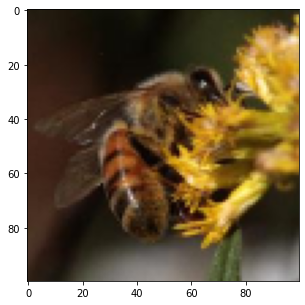

In [ ]:
# verify result (using test image)
verify_unbalanced_cnn = verify_pic_cnn(unbalanced_cnn,"2649","/content/AI Tech Bees/datasets/Images/")
print(verify_unbalanced_cnn)

### **Balanced Data**

In [ ]:
# get the value count of each genus
count_label_1, count_label_0 = labels.genus.value_counts()

# extract bombus and apis
label_0 = labels[labels['genus'] == 0.0]
label_1 = labels[labels['genus'] == 1.0]

# print out its shape
print("Label 0 shape:", label_0.shape)
print("Label 1 shape:", label_1.shape)

# randomly oversample label_0 to match label_1
label_0_over = label_0.sample(count_label_1, replace=True, random_state=42)
labels_ros = pd.concat([label_0_over, label_1], axis=0)

# # write the balanced dataset to file
# labels_ros.to_csv('/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/datasets/labels_balanced.csv')

Label 0 shape: (827, 1)
Label 1 shape: (3142, 1)


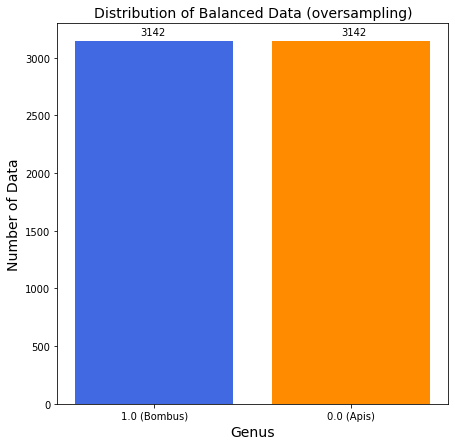

In [ ]:
# look at the distribution of the dataset
plt.figure(figsize=(7,7))
plt.bar(['1.0 (Bombus)','0.0 (Apis)'], labels_ros.genus.value_counts(), color=['royalblue','darkorange'])
plt.xlabel("Genus", fontsize=14)
plt.ylabel("Number of Data", fontsize=14)
plt.title("Distribution of Balanced Data (oversampling)", fontsize=14)
plt.annotate(labels_ros.genus.value_counts()[1],(-0.07,3200))
plt.annotate(labels_ros.genus.value_counts()[0],(0.95,3200))
plt.show()

In [ ]:
# # resize balanced images
# resize_img(labels_ros, "/content/AI Tech Bees/datasets/Images/", "/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/datasets/resized_image_balanced/")

# create matrix
balanced_feature_matrix = create_feature_matrix(labels_ros, "/content/AI Tech Bees/datasets/resized_image_balanced/")

# splitting balanced data
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(balanced_feature_matrix, labels_ros['genus'].values, test_size=0.2, random_state=0)

# call reduce dimensionality function
X_train_ros_reduced, X_test_ros_reduced, ss_verify_ros, pca_verify_ros = scale_reduce_features(X_train_ros, X_test_ros, 375)

#### **SVM**

In [ ]:
# define support vector classifier
svm_ros = SVC(probability = True, class_weight = 'balanced', random_state = 42)
svm_bag_ros = BaggingClassifier(svm_ros, max_samples = 0.1, n_estimators = 20, random_state = 16, n_jobs = -1)

param_grid = {'base_estimator__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
              'base_estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'base_estimator__kernel': ['poly', 'sigmoid', 'rbf', 'linear'],
              'base_estimator__degree': [3]}
 
svm_grid_ros = GridSearchCV(svm_bag_ros, param_grid, refit = True, verbose = 4, scoring='accuracy')

# # fit and save model
# svm_grid_ros.fit(X_train_ros_reduced,y_train_ros)
# joblib.dump(svm_grid_ros, '/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/balanced_svm')

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=poly;, score=0.850 total time=   5.9s
[CV 2/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=poly;, score=0.815 total time=   5.4s
[CV 3/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=poly;, score=0.813 total time=   4.3s
[CV 4/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=poly;, score=0.828 total time=   4.3s
[CV 5/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=poly;, score=0.864 total time=   4.4s
[CV 1/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=sigmoid;, score=0.603 total time=   4.3s
[CV 2/5] END base_estimator__C=0.0

['/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/balanced_svm1']

In [ ]:
# load model
balanced_svm = joblib.load('/content/AI Tech Bees/model/balanced_svm')

# print best parameter after tuning
print(balanced_svm.best_params_)
 
# print how the model looks after hyper-parameter tuning
print(balanced_svm.best_estimator_)

{'base_estimator__C': 0.001, 'base_estimator__degree': 3, 'base_estimator__gamma': 1, 'base_estimator__kernel': 'poly'}
BaggingClassifier(base_estimator=SVC(C=0.001, class_weight='balanced', gamma=1,
                                     kernel='poly', probability=True,
                                     random_state=42),
                  max_samples=0.1, n_estimators=20, n_jobs=-1, random_state=16)


In [ ]:
# generate predictions
y_pred_svm_ros = balanced_svm.predict(X_test_ros_reduced)

# calculate accuracy
accuracy_svm_ros = accuracy_score(y_test_ros, y_pred_svm_ros)
print('SVM accuracy (Balanced): ', accuracy_svm_ros)

SVM accuracy (Balanced):  0.8392999204455052


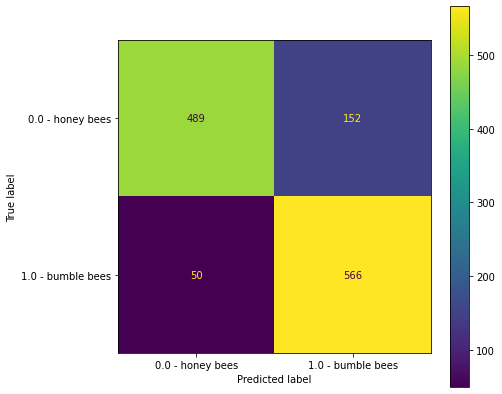

In [ ]:
# plot confusion matrix
plot_confusion_matrix(y_test_ros, y_pred_svm_ros)

AUC Score:  0.9040586948153251


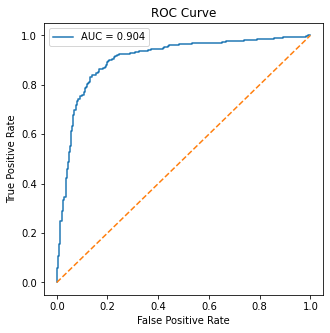

In [ ]:
# plot ROC curve
plot_roc_auc(y_test_ros, CNN = False, clf = balanced_svm, X_test = X_test_ros_reduced)

1.0 - Bumble bee - Bombus - (57.24% accuracy)


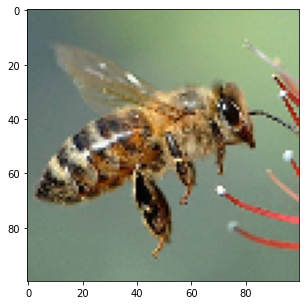

In [ ]:
# verify result
verify_balanced_svm = verify_pic(balanced_svm,"honeybee1","/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/datasets/verify_images/", ss_verify_ros, pca_verify_ros)
print(verify_balanced_svm)

0.0 - Honey bee - Apis - (72.67% accuracy)


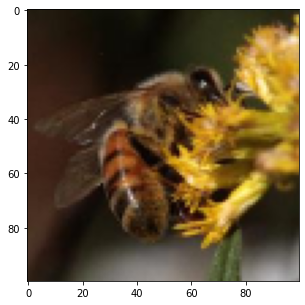

In [ ]:
# verify result (using test image)
verify_balanced_svm = verify_pic(balanced_svm,"2649","/content/AI Tech Bees/datasets/Images/", ss_verify_ros, pca_verify_ros)
print(verify_balanced_svm)

#### **Logistic Regression**

In [ ]:
# define logistic regression
lr_ros = LogisticRegression()

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'max_iter': [500, 1000, 4000, 7000, 10000],
              'penalty': ['l2'],
              'random_state': [42]}
 
lr_grid_ros = GridSearchCV(lr_ros, param_grid, refit = True, verbose = 4, scoring='accuracy')

# # fit and save model
# lr_grid_ros.fit(X_train_ros_reduced,y_train_ros)
# joblib.dump(lr_grid_ros, '/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/balanced_lr')

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=newton-cg;, score=0.735 total time=   1.1s
[CV 2/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=newton-cg;, score=0.714 total time=   1.0s
[CV 3/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=newton-cg;, score=0.727 total time=   1.1s
[CV 4/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=newton-cg;, score=0.717 total time=   0.9s
[CV 5/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=newton-cg;, score=0.726 total time=   1.0s
[CV 1/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=lbfgs;, score=0.735 total time=   0.3s
[CV 2/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=lbfgs;, score=0.714 total time=   0.3s
[CV 3/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=lbfgs;, score=0.727 total time=   0.3s
[CV 4/5] END C=0.0001,

['/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/balanced_lr']

In [ ]:
# load model
balanced_lr = joblib.load('/content/AI Tech Bees/model/balanced_lr')

# print best parameter after tuning
print(balanced_lr.best_params_)
 
# print how the model looks after hyper-parameter tuning
print(balanced_lr.best_estimator_)

{'C': 0.0001, 'max_iter': 500, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}
LogisticRegression(C=0.0001, max_iter=500, random_state=42, solver='liblinear')


In [ ]:
# generate predictions
y_pred_lr_ros = balanced_lr.predict(X_test_ros_reduced)

# calculate accuracy
accuracy_lr_ros = accuracy_score(y_test_ros,y_pred_lr_ros)
print('LR accuracy (Balanced): ', accuracy_lr_ros)

LR accuracy (Balanced):  0.7064439140811456


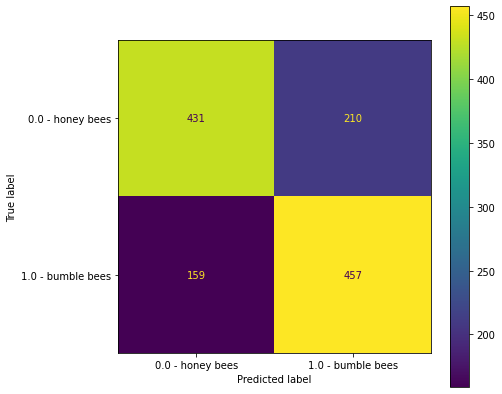

In [ ]:
# plot confusion matrix
plot_confusion_matrix(y_test_ros,y_pred_lr_ros)

AUC Score:  0.768649836902567


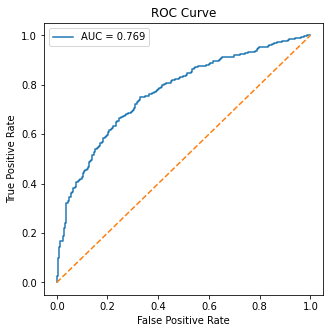

In [ ]:
# plot ROC curve
plot_roc_auc(y_test_ros, CNN = False, clf = balanced_lr, X_test = X_test_ros_reduced)

0.0 - Honey bee - Apis - (53.19% accuracy)


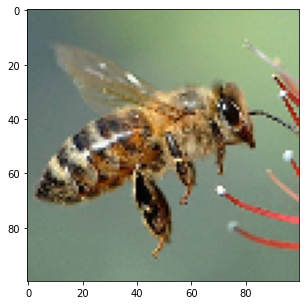

In [ ]:
# verify result
verify_balanced_lr = verify_pic(balanced_lr,"honeybee1","/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/datasets/verify_images/", ss_verify_ros, pca_verify_ros)
print(verify_balanced_lr)

0.0 - Honey bee - Apis - (58.00% accuracy)


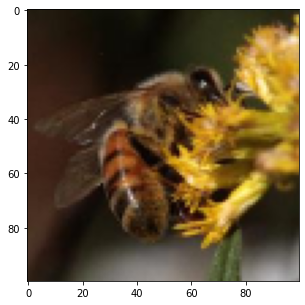

In [ ]:
# verify result (using test image)
verify_balanced_svm = verify_pic(balanced_lr,"2649","/content/AI Tech Bees/datasets/Images/", ss_verify_ros, pca_verify_ros)
print(verify_balanced_svm)

#### **CNN**

In [ ]:
# create features
path = "/content/AI Tech Bees/datasets/resized_image_balanced/"
cnn_features_ros = create_features_cnn(labels_ros, path)

# split data into 80% train, 10% eval, 10% test
X_train_cnn_ros, X_test_and_val_ros, y_train_cnn_ros, y_test_and_val_ros = train_test_split(cnn_features_ros,
                                                    labels_ros.genus.values,
                                                    test_size=0.2,
                                                    random_state=102
                                                    )

X_test_cnn_ros, X_val_cnn_ros, y_test_cnn_ros, y_val_cnn_ros = train_test_split(X_test_and_val_ros,
                                                    y_test_and_val_ros,
                                                    test_size=0.5,
                                                    random_state=102
                                                    )

In [ ]:
# build a model
img_rows, img_cols = 100, 100 # Resolution of inputs
color_channel = 3 # rgb
num_classes = 2  # apis and bombus

# change the labels to categorical
y_train_cnn_ros = to_categorical(y_train_cnn_ros, num_classes)
y_val_cnn_ros = to_categorical(y_val_cnn_ros, num_classes)

# initialize InceptionV3 as our base model
base_model_ros =  InceptionV3(weights='imagenet', include_top=False)
    
# input format
input_ros = Input(shape=(img_rows,img_cols,color_channel),name = 'image_input')

# connect the model together
output_base_model_ros = base_model_ros(input_ros)

# add layers 
x_ros = Flatten(name='flatten')(output_base_model_ros)
x_ros = Dropout(0.3)(x_ros)
x_ros = Dense(512, activation='relu', name='fc1', kernel_regularizer=l2(1e-4))(x_ros)
x_ros = Dropout(0.5)(x_ros)
x_ros = Dense(512, activation='relu', name='fc2', kernel_regularizer=l2(1e-4))(x_ros)
x_ros = Dropout(0.5)(x_ros)
x_ros = Dense(num_classes, activation='softmax', name='predictions')(x_ros)

balanced_cnn = Model(input_ros, x_ros)

# print out the model summary
balanced_cnn.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 fc1 (Dense)                 (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                              

In [ ]:
# compile model
balanced_cnn.compile(loss = "categorical_crossentropy", optimizer = 'sgd', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min', min_delta=0.0001)

# # train model
# balanced_cnn_history = balanced_cnn.fit(X_train_cnn_ros, y_train_cnn_ros, batch_size = 20, epochs = 20, shuffle = True, verbose = 1,
#                                         validation_data = (X_val_cnn_ros, y_val_cnn_ros), callbacks=[early_stopping])

# # save model
# balanced_cnn.save('/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/balaced_cnn.h5')
# joblib.dump(balanced_cnn_history, '/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/balanced_cnn_history')

Epoch 1/20
252/252 [==============================] - 42s 137ms/step - loss: 0.8362 - accuracy: 0.5886 - val_loss: 0.7539 - val_accuracy: 0.6757
Epoch 2/20
252/252 [==============================] - 33s 130ms/step - loss: 0.6177 - accuracy: 0.7893 - val_loss: 0.6109 - val_accuracy: 0.8331
Epoch 3/20
252/252 [==============================] - 33s 131ms/step - loss: 0.4115 - accuracy: 0.8936 - val_loss: 0.3656 - val_accuracy: 0.9126
Epoch 4/20
252/252 [==============================] - 33s 130ms/step - loss: 0.3121 - accuracy: 0.9340 - val_loss: 0.3419 - val_accuracy: 0.9253
Epoch 5/20
252/252 [==============================] - 33s 130ms/step - loss: 0.2626 - accuracy: 0.9558 - val_loss: 0.2717 - val_accuracy: 0.9459
Epoch 6/20
252/252 [==============================] - 33s 130ms/step - loss: 0.2211 - accuracy: 0.9702 - val_loss: 0.3258 - val_accuracy: 0.9459
Epoch 7/20
252/252 [==============================] - 33s 130ms/step - loss: 0.1996 - accuracy: 0.9765 - val_loss: 0.3329 - val_ac

['/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/balanced_cnn_history']

CNN accuracy (Balanced):  0.982484076433121


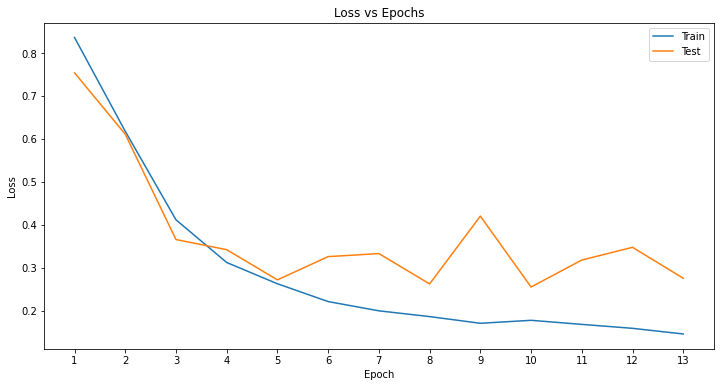

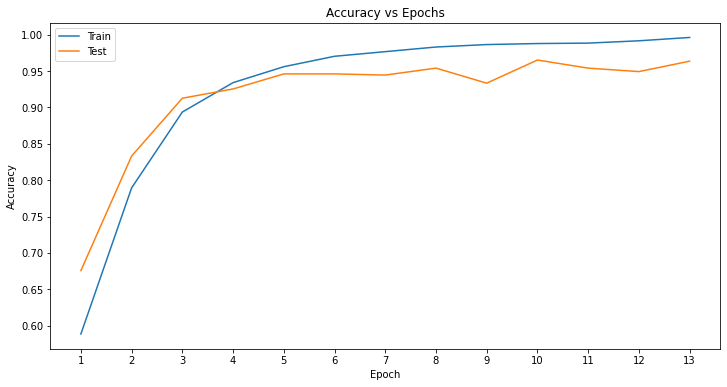

In [ ]:
# load model
balanced_cnn = load_model('/content/AI Tech Bees/model/balaced_cnn.h5')
balanced_cnn_history = joblib.load('/content/AI Tech Bees/model/balanced_cnn_history')

# generate predictions
y_pred_cnn_ros = balanced_cnn.predict(X_test_cnn_ros)
y_pred_cnn_ros = y_pred_cnn_ros.argmax(axis=-1)

# calculate accuracy
accuracy_cnn_ros = accuracy_score(y_test_cnn_ros,y_pred_cnn_ros)
print('CNN accuracy (Balanced): ', accuracy_cnn_ros)

# plot graphs
plot_vs_epochs(balanced_cnn_history,13)

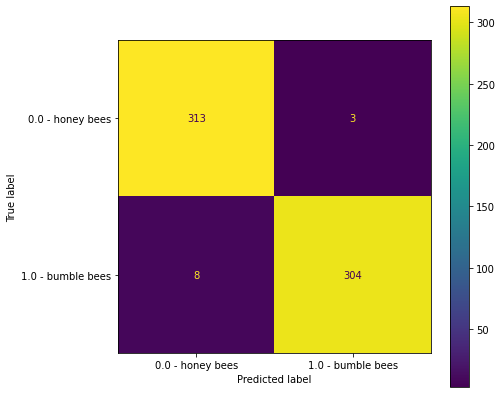

In [ ]:
# plot confusion matrix
plot_confusion_matrix(y_test_cnn_ros,y_pred_cnn_ros)

AUC Score:  0.9824326517364492


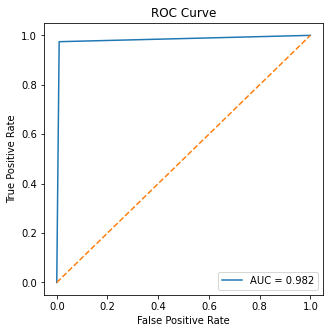

In [ ]:
# plot ROC curve
plot_roc_auc(y_test_cnn_ros, CNN = True, y_pred = y_pred_cnn_ros)

0.0 - Honey bee - Apis - (99.99% accuracy)


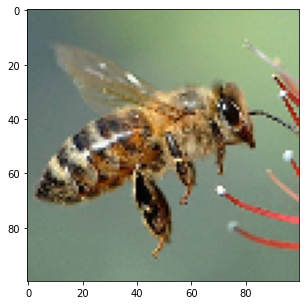

In [ ]:
# verify result
verify_balanced_cnn = verify_pic_cnn(balanced_cnn,"honeybee1","/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/datasets/verify_images/")
print(verify_balanced_cnn)

0.0 - Honey bee - Apis - (99.99% accuracy)


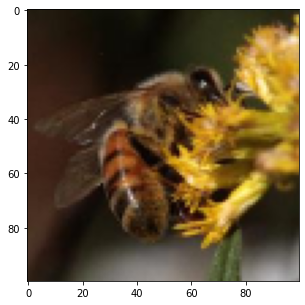

In [ ]:
# verify result (using test image)
verify_balanced_cnn = verify_pic_cnn(balanced_cnn,"2649","/content/AI Tech Bees/datasets/Images/")
print(verify_balanced_cnn)

### **Optimized Balanced Data**

In [ ]:
file_list = listdir(r"/content/AI Tech Bees/datasets/Optimized_Images/Bad pic")
index_file = []

# get bad images id
for files in file_list:
   x = files[:-4]
   index_file.append(x)

# make a copy of original dataframe and delete bad images id
op_labels = labels.copy()
counter = 0
value = []

for index,row in labels.iterrows():
    if str(row.name) in index_file:
        op_labels.drop(row.name, axis = 0, inplace = True)

print("Shape of dataset after optimizing:", op_labels.shape)

Shape of dataset after optimizing: (3002, 1)


In [ ]:
# get the value count of each genus
count_label_1, count_label_0 = op_labels.genus.value_counts()

# extract bombus and apis
optimized_labels_0 = op_labels[op_labels['genus'] == 0.0]
optimized_labels_1 = op_labels[op_labels['genus'] == 1.0]

# print out its shape
print("Label 0 shape:", optimized_labels_0.shape)
print("Label 1 shape:", optimized_labels_1.shape)

# randomly oversample label_0 to match label_1
optimized_labels_0_over = optimized_labels_0.sample(count_label_1, replace=True, random_state=42)
optimized_labels_ros = pd.concat([optimized_labels_0_over, optimized_labels_1], axis=0)

# # write the balanced dataset to file
# optimized_labels_ros.to_csv('/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/datasets/labels_optimized_balanced.csv')

Label 0 shape: (554, 1)
Label 1 shape: (2448, 1)


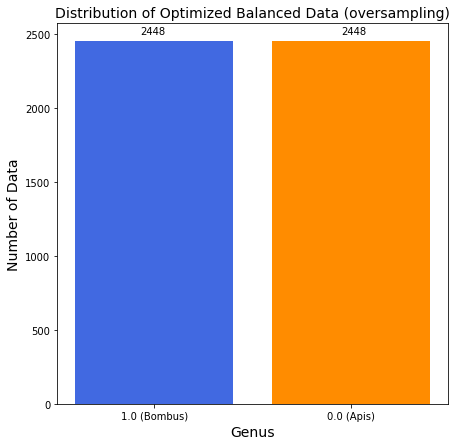

In [ ]:
# look at the distribution of the dataset
plt.figure(figsize=(7,7))
plt.bar(['1.0 (Bombus)','0.0 (Apis)'], optimized_labels_ros.value_counts(), color=['royalblue','darkorange'])
plt.xlabel("Genus", fontsize=14)
plt.ylabel("Number of Data", fontsize=14)
plt.title("Distribution of Optimized Balanced Data (oversampling)", fontsize=14)
plt.annotate(optimized_labels_ros.value_counts()[1],(-0.07,2500))
plt.annotate(optimized_labels_ros.value_counts()[0],(0.95,2500))
plt.show()

In [ ]:
# # resize balanced images
# resize_img(optimized_labels_ros, "/content/AI Tech Bees/datasets/Optimized_Images/Good pic/", "/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/datasets/resized_optimized_image_balanced/")

# create matrix
balanced_feature_matrix_op = create_feature_matrix(optimized_labels_ros, "/content/AI Tech Bees/datasets/resized_optimized_image_balanced/")

# splitting unbalanced data
X_train_op, X_test_op, y_train_op, y_test_op = train_test_split(balanced_feature_matrix_op, optimized_labels_ros['genus'].values, test_size=0.2, random_state=0)

# call reduce dimensionality function
X_train_op_reduced, X_test_op_reduced, ss_verify_op, pca_verify_op = scale_reduce_features(X_train_op, X_test_op, 375)

#### **SVM**

In [ ]:
# define support vector classifier
svm_op = SVC(probability = True, class_weight = 'balanced', random_state = 42)
svm_bag_op = BaggingClassifier(svm_op, max_samples = 0.1, n_estimators = 20, random_state = 16, n_jobs = -1)

param_grid = {'base_estimator__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
              'base_estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'base_estimator__kernel': ['poly', 'sigmoid', 'rbf', 'linear'],
              'base_estimator__degree': [3]}
 
svm_grid_op = GridSearchCV(svm_bag_op, param_grid, refit = True, verbose = 4, scoring='accuracy')

# # fit and save model
# svm_grid_op.fit(X_train_op_reduced,y_train_op)
# joblib.dump(svm_grid_op, '/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/balanced_op_svm')

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=poly;, score=0.865 total time=   3.1s
[CV 2/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=poly;, score=0.808 total time=   2.8s
[CV 3/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=poly;, score=0.860 total time=   2.8s
[CV 4/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=poly;, score=0.877 total time=   2.7s
[CV 5/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=poly;, score=0.848 total time=   2.8s
[CV 1/5] END base_estimator__C=0.001, base_estimator__degree=3, base_estimator__gamma=1, base_estimator__kernel=sigmoid;, score=0.659 total time=   2.9s
[CV 2/5] END base_estimator__C=0.0

['/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/balanced_op_svm']

In [ ]:
# load model
balanced_op_svm = joblib.load('/content/AI Tech Bees/model/balanced_op_svm')

# print best parameter after tuning
print(balanced_op_svm.best_params_)
 
# print how the model looks after hyper-parameter tuning
print(balanced_op_svm.best_estimator_)

{'base_estimator__C': 0.001, 'base_estimator__degree': 3, 'base_estimator__gamma': 0.001, 'base_estimator__kernel': 'poly'}
BaggingClassifier(base_estimator=SVC(C=0.001, class_weight='balanced',
                                     gamma=0.001, kernel='poly',
                                     probability=True, random_state=42),
                  max_samples=0.1, n_estimators=20, n_jobs=-1, random_state=16)


In [ ]:
# generate predictions
y_pred_svm_op = balanced_op_svm.predict(X_test_op_reduced)

# calculate accuracy
accuracy_svm_op = accuracy_score(y_test_op, y_pred_svm_op)
print('SVM accuracy (Balanced,Optimized): ', accuracy_svm_op)

SVM accuracy (Balanced,Optimized):  0.8520408163265306


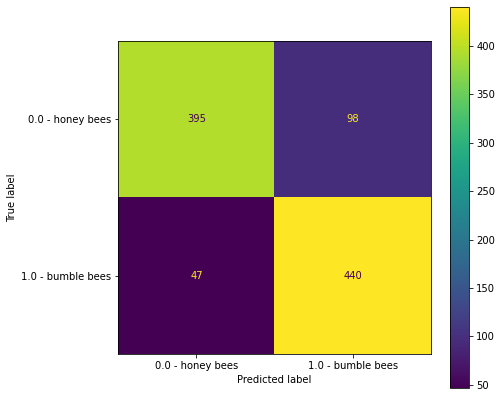

In [ ]:
# plot confusion matrix
plot_confusion_matrix(y_test_op, y_pred_svm_op)

AUC Score:  0.9224585677930451


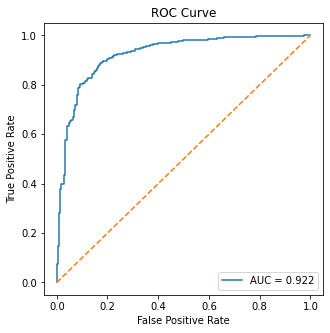

In [ ]:
# plot ROC curve
plot_roc_auc(y_test_op, CNN = False, clf = balanced_op_svm, X_test = X_test_op_reduced)

1.0 - Bumble bee - Bombus - (57.91% accuracy)


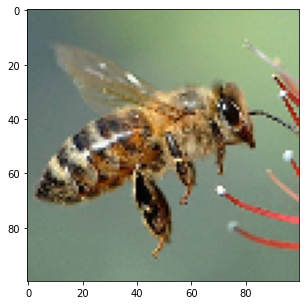

In [ ]:
# verify result
verify_balanced_op_svm = verify_pic(balanced_op_svm,"honeybee1","/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/datasets/verify_images/", ss_verify_op, pca_verify_op)
print(verify_balanced_op_svm)

0.0 - Honey bee - Apis - (63.16% accuracy)


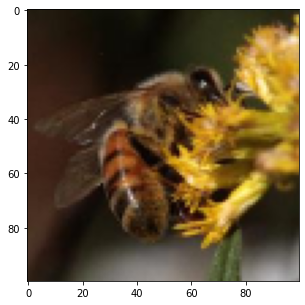

In [ ]:
# verify result (using test image)
verify_balanced_op_svm = verify_pic(balanced_op_svm,"2649","/content/AI Tech Bees/datasets/Images/", ss_verify_op, pca_verify_op)
print(verify_balanced_op_svm)

#### **Logistic Regression**

In [ ]:
# define logistic regression
lr_op = LogisticRegression()

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'max_iter': [500, 1000, 4000, 7000, 10000],
              'penalty': ['l2'],
              'random_state': [42]}
 
lr_grid_op = GridSearchCV(lr_op, param_grid, refit = True, verbose = 4, scoring='accuracy')

# # fit and save model
# lr_grid_op.fit(X_train_op_reduced,y_train_op)
# joblib.dump(lr_grid_op, '/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/balanced_op_lr')

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=newton-cg;, score=0.782 total time=   0.8s
[CV 2/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=newton-cg;, score=0.761 total time=   0.8s
[CV 3/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=newton-cg;, score=0.777 total time=   0.6s
[CV 4/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=newton-cg;, score=0.764 total time=   0.7s
[CV 5/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=newton-cg;, score=0.782 total time=   0.6s
[CV 1/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=lbfgs;, score=0.782 total time=   0.2s
[CV 2/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=lbfgs;, score=0.761 total time=   0.2s
[CV 3/5] END C=0.0001, max_iter=500, penalty=l2, random_state=42, solver=lbfgs;, score=0.775 total time=   0.2s
[CV 4/5] END C=0.0001,

['/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/balanced_op_lr']

In [ ]:
# load model
balanced_op_lr = joblib.load('/content/AI Tech Bees/model/balanced_op_lr')

# print best parameter after tuning
print(balanced_op_lr.best_params_)
 
# print how the model looks after hyper-parameter tuning
print(balanced_op_lr.best_estimator_)

{'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg'}
LogisticRegression(C=0.001, max_iter=500, random_state=42, solver='newton-cg')


In [ ]:
# generate predictions
y_pred_lr_op = balanced_op_lr.predict(X_test_op_reduced)

# calculate accuracy
accuracy_lr_op = accuracy_score(y_test_op,y_pred_lr_op)
print('LR accuracy (Balanced,Optimized): ', accuracy_lr_op)

LR accuracy (Balanced,Optimized):  0.7153061224489796


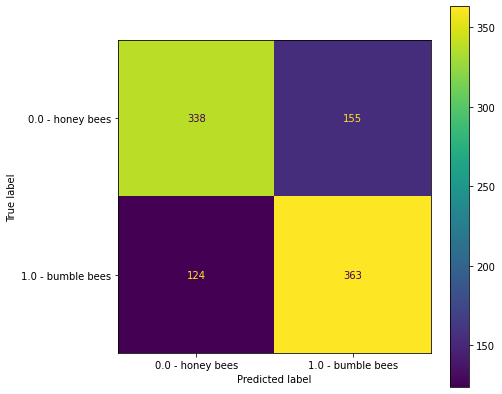

In [ ]:
# plot confusion matrix
plot_confusion_matrix(y_test_op,y_pred_lr_op)

AUC Score:  0.8038077229050651


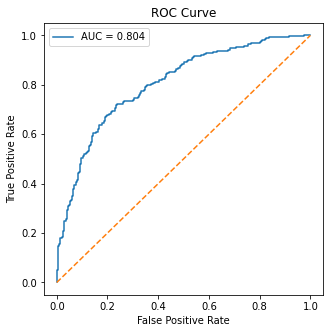

In [ ]:
# plot ROC curve
plot_roc_auc(y_test_op, CNN = False, clf = balanced_op_lr, X_test = X_test_op_reduced)

0.0 - Honey bee - Apis - (62.40% accuracy)


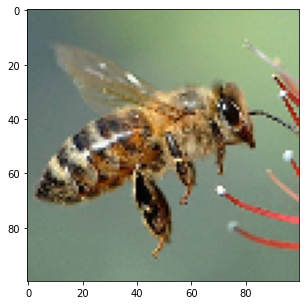

In [ ]:
# verify result
verify_balanced_op_lr = verify_pic(balanced_op_lr,"honeybee1","/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/datasets/verify_images/", ss_verify_op, pca_verify_op)
print(verify_balanced_op_lr)

0.0 - Honey bee - Apis - (60.42% accuracy)


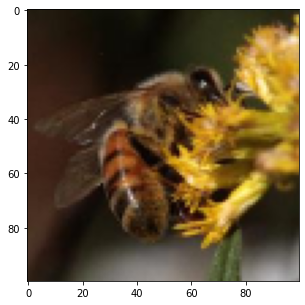

In [ ]:
# verify result (using test image)
verify_balanced_op_svm = verify_pic(balanced_op_lr,"2649","/content/AI Tech Bees/datasets/Images/", ss_verify_op, pca_verify_op)
print(verify_balanced_op_svm)

#### **CNN**

In [ ]:
# create features
path = "/content/AI Tech Bees/datasets/resized_optimized_image_balanced/"
cnn_features_op = create_features_cnn(optimized_labels_ros, path)

# split data into 80% train, 10% eval, 10% test
X_train_cnn_op, X_test_and_val_op, y_train_cnn_op, y_test_and_val_op = train_test_split(cnn_features_op,
                                                    optimized_labels_ros.genus.values,
                                                    test_size=0.2,
                                                    random_state=102
                                                    )

X_test_cnn_op, X_val_cnn_op, y_test_cnn_op, y_val_cnn_op = train_test_split(X_test_and_val_op,
                                                    y_test_and_val_op,
                                                    test_size=0.5,
                                                    random_state=102
                                                    )

In [ ]:
# build a model
img_rows, img_cols = 100, 100 # Resolution of inputs
color_channel = 3 # rgb
num_classes = 2  # apis and bombus

# change the labels to categorical
y_train_cnn_op = to_categorical(y_train_cnn_op, num_classes)
y_val_cnn_op = to_categorical(y_val_cnn_op, num_classes)

# initialize InceptionV3 as our base model
base_model_op =  InceptionV3(weights='imagenet', include_top=False)
    
# input format
input_op = Input(shape=(img_rows,img_cols,color_channel),name = 'image_input')

# connect the model together
output_base_model_op = base_model_op(input_op)

# add layers 
x_op = Flatten(name='flatten')(output_base_model_op)
x_op = Dropout(0.3)(x_op)
x_op = Dense(512, activation='relu', name='fc1', kernel_regularizer=l2(1e-4))(x_op)
x_op = Dropout(0.5)(x_op)
x_op = Dense(512, activation='relu', name='fc2', kernel_regularizer=l2(1e-4))(x_op)
x_op = Dropout(0.5)(x_op)
x_op = Dense(num_classes, activation='softmax', name='predictions')(x_op)

balanced_op_cnn = Model(input_op, x_op)

# print out the model summary
balanced_op_cnn.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout_63 (Dropout)        (None, 2048)              0         
                                                                 
 fc1 (Dense)                 (None, 512)               1049088   
                                                                 
 dropout_64 (Dropout)        (None, 512)               0         
                                                                 
 fc2 (Dense)                 (None, 512)               262

In [ ]:
# compile model
balanced_op_cnn.compile(loss = "categorical_crossentropy", optimizer = 'sgd', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min', min_delta=0.0001)

# # train model
# balanced_op_cnn_history = balanced_op_cnn.fit(X_train_cnn_op, y_train_cnn_op, batch_size = 20, epochs = 20, shuffle = True, verbose = 1,
#                                         validation_data = (X_val_cnn_op, y_val_cnn_op), callbacks=[early_stopping])

# # save model
# balanced_op_cnn.save('/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/balaced_op_cnn.h5')
# joblib.dump(balanced_op_cnn_history, '/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/balanced_op_cnn_history')

Epoch 1/20
196/196 [==============================] - 36s 142ms/step - loss: 0.7932 - accuracy: 0.6239 - val_loss: 0.7960 - val_accuracy: 0.5694
Epoch 2/20
196/196 [==============================] - 26s 131ms/step - loss: 0.5067 - accuracy: 0.8685 - val_loss: 0.3461 - val_accuracy: 0.9265
Epoch 3/20
196/196 [==============================] - 26s 132ms/step - loss: 0.3608 - accuracy: 0.9305 - val_loss: 0.2701 - val_accuracy: 0.9531
Epoch 4/20
196/196 [==============================] - 26s 131ms/step - loss: 0.2699 - accuracy: 0.9594 - val_loss: 0.2574 - val_accuracy: 0.9612
Epoch 5/20
196/196 [==============================] - 26s 132ms/step - loss: 0.2381 - accuracy: 0.9711 - val_loss: 0.2383 - val_accuracy: 0.9653
Epoch 6/20
196/196 [==============================] - 26s 132ms/step - loss: 0.1988 - accuracy: 0.9829 - val_loss: 0.2124 - val_accuracy: 0.9796
Epoch 7/20
196/196 [==============================] - 26s 132ms/step - loss: 0.1915 - accuracy: 0.9842 - val_loss: 0.2577 - val_ac

['/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/model/balanced_op_cnn_history']

CNN accuracy (Balanced,Optimized):  0.9836734693877551


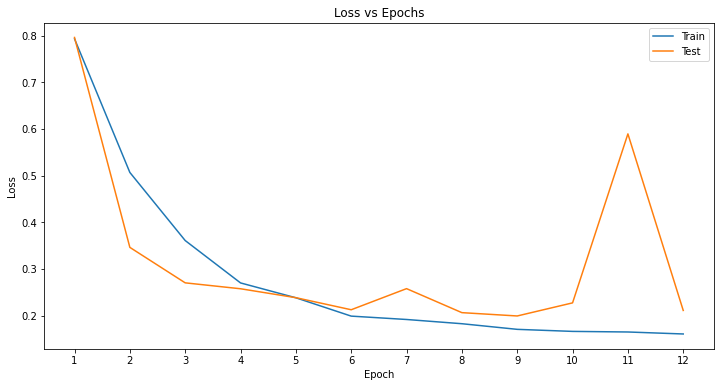

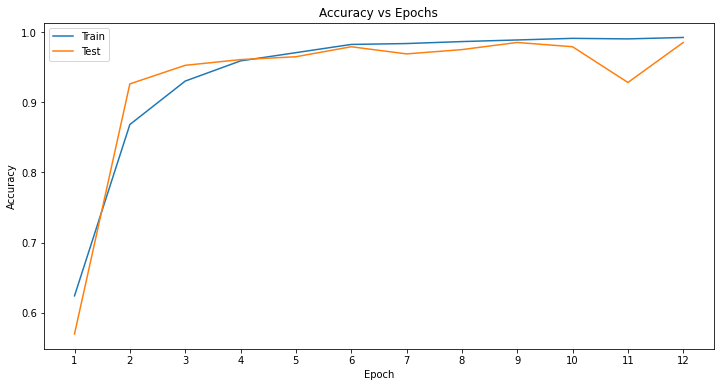

In [ ]:
# load model
balanced_op_cnn = load_model('/content/AI Tech Bees/model/balaced_op_cnn.h5')
balanced_op_cnn_history = joblib.load('/content/AI Tech Bees/model/balanced_op_cnn_history')

# generate predictions
y_pred_cnn_op = balanced_op_cnn.predict(X_test_cnn_op)
y_pred_cnn_op = y_pred_cnn_op.argmax(axis=-1)

# calculate accuracy
accuracy_cnn_op = accuracy_score(y_test_cnn_op,y_pred_cnn_op)
print('CNN accuracy (Balanced,Optimized): ', accuracy_cnn_op)

# plot graphs
plot_vs_epochs(balanced_op_cnn_history,12)

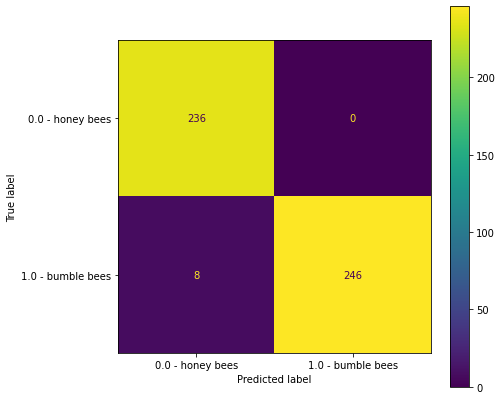

In [ ]:
# plot confusion matrix
plot_confusion_matrix(y_test_cnn_op,y_pred_cnn_op)

AUC Score:  0.984251968503937


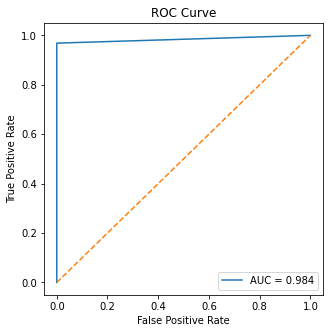

In [ ]:
# plot ROC curve
plot_roc_auc(y_test_cnn_op, CNN = True, y_pred = y_pred_cnn_op)

0.0 - Honey bee - Apis - (100.00% accuracy)


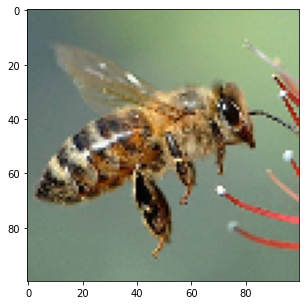

In [ ]:
# verify result
verify_balanced_op_cnn = verify_pic_cnn(balanced_op_cnn,"honeybee1","/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/datasets/verify_images/")
print(verify_balanced_op_cnn)

0.0 - Honey bee - Apis - (99.90% accuracy)


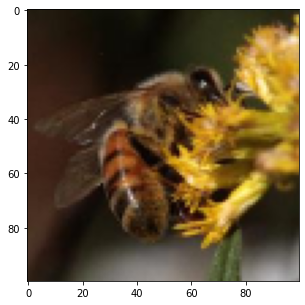

In [ ]:
# verify result (using test image)
verify_balanced_op_cnn = verify_pic_cnn(balanced_op_cnn,"2649","/content/AI Tech Bees/datasets/Images/")
print(verify_balanced_op_cnn)

## Deploy a model on test site

To make our model usable for the regular user, we made a simple website that allows the user to upload the bees image and the AI will classify it as well as telling how confident it is.

In [ ]:
# install required apps
!pip install -q streamlit
!pip install -q pyngrok==4.1.1

In [ ]:
# make css file for styling
%%writefile app.css

header, footer {
    visibility: hidden;
}

#MainMenu {
    visibility: hidden;
}

.block-container{
    padding: 0px 0px 40px;
}

Overwriting app.css


In [ ]:
# main website content
%%writefile app.py
import streamlit as st
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import numpy as np

# setup page
CURRENT_THEME = "dark"
IS_DARK_THEME = True
st.set_page_config(page_title='Bees Classifier', page_icon="🐝")
st.set_option('deprecation.showfileUploaderEncoding', False) # disable deprecation error
with open("app.css") as f:
    st.markdown('<style>{}</style>'.format(f.read()), unsafe_allow_html=True)

# picture banner
image = Image.open('/content/drive/MyDrive/Colab Notebooks/AI Tech Bees/etc/Banner.png')
st.image(image)

st.header("AI that classifies Honey bees and Bumble bees.")
st.caption("by Piyawud Koonmanee, Nithiwat Pattrapong, Tulatorn Prakitjanuruk, Chananyu Kamolsuntron")

# load CNN model
@st.cache(allow_output_mutation = True)     # enable cache to improve the loading time
def get_model():
    model = load_model('/content/AI Tech Bees/model/balaced_op_cnn.h5')
    return model

with st.spinner('Loading Model...'):
    model = get_model()

# file uploader
img = st.file_uploader("Please upload the file", type=["jpg"])

# perform prediction
if img is not None:
    img = Image.open(img)
    img = img.convert('RGB')
    
    # display centered picture
    col1, col2, col3 = st.columns([1,4,1])
    with col1:
        st.write('')
    with col2:
        st.image(img, caption="Predicting image")
    with col3:
        st.write('')

    # resize the image to 100x100 pixels
    img = img.resize((100,100))

    # scale down the data
    data = np.asarray(img) / 255.0

    # expan dimension for CNN layers
    data = np.expand_dims(data, axis=0)

    # predict
    prediction = model.predict(data)

    # get maximum value
    classes = np.argmax(prediction, axis = 1)

    if classes == 1.0:
        result = "I'm " + str(np.round(np.max(prediction)*100,2)) +"% sure that this is a Bumble bee (genus Bombus)."
        st.subheader(result)
    else:
        result = "I'm " + str(np.round(np.max(prediction)*100,2)) +"% sure that this is a Honey bee (genus Apis)."
        st.subheader(result)

Overwriting app.py


In [ ]:
# run app.py in the background
!ngrok authtoken 27uaLBMFL10HeCK1hqi1VjeNTxj_NcACLJKJCgi4CwsntB1k # do not share!
!streamlit run app.py&>/dev/null& 

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
# start web tunneling
from pyngrok import ngrok

ngrok.kill()
public_url = ngrok.connect(port='8502')
print(public_url)

2022-04-23 15:05:38.907 INFO    pyngrok.process: Killing ngrok process: 12166
2022-04-23 15:05:38.957 INFO    pyngrok.process: ngrok process starting: 12234
2022-04-23 15:05:39.033 INFO    pyngrok.process: t=2022-04-23T15:05:39+0000 lvl=info msg="no configuration paths supplied"

2022-04-23 15:05:39.046 INFO    pyngrok.process: t=2022-04-23T15:05:39+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml

2022-04-23 15:05:39.048 INFO    pyngrok.process: t=2022-04-23T15:05:39+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil

2022-04-23 15:05:39.057 INFO    pyngrok.process: t=2022-04-23T15:05:39+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040

2022-04-23 15:05:39.187 INFO    pyngrok.process: t=2022-04-23T15:05:39+0000 lvl=info msg="tunnel session started" obj=tunnels.session

2022-04-23 15:05:39.193 INFO    pyngrok.process: t=2022-04-23T15:05:39+0000 lvl=info msg="client session established" obj=csess id=3c

http://6603-35-193-152-187.ngrok.io


2022-04-23 15:05:39.304 INFO    pyngrok.process: t=2022-04-23T15:05:39+0000 lvl=info msg="started tunnel" obj=tunnels name=http-8502-72634e0a-a8b2-48ca-b63c-5720049ccffd addr=http://localhost:8502 url=https://6603-35-193-152-187.ngrok.io

2022-04-23 15:05:39.307 INFO    pyngrok.process: t=2022-04-23T15:05:39+0000 lvl=info msg=end pg=/api/tunnels id=59ae51c4bc6fd44e status=201 dur=81.475165ms



In [ ]:
# kill the process when there is an error
!killall ngrok

2022-04-23 15:08:10.209 INFO    pyngrok.process: t=2022-04-23T15:08:10+0000 lvl=info msg="received stop request" obj=app stopReq="{err:<nil> restart:false}"

